# Calculation of the heat transfer coefficient of air

The heat transfer coefficient is an equivalen thermal conductivity that takes into account sensible and latent heat flux at the land surface. Using a heat transfer coefficient means that heat transport at the surface can be modeled using a standard diffusion equation, without explicitely modeling the sesnible and latent heat fluxes. This is important for accurate models of surface temperatures, for instance around thermal springs

In [26]:
import numpy as np
import matplotlib.pyplot as pl

first lets define some of the parameters that are needed:

In [27]:
# density of air
rho = 1.29

# heat capacity
c = 1000.0

# measurement height for aerodynamic resistance 
dz = 2.0

# aerodynamic resistance
ras_plot = [80.0]

# reference wind speed for plotting (m/s)
u_ref = 2.0

# wind speed for calculating ra:
u = np.linspace(1.0, 5.0, 41)

# air temperature
Ta = 10.0

# surface temperature
Ts_plot = np.arange(Ta + 1, 101, 1.0)

# specific latent heat of vaporisation
L = 2.264e6

# air pressure
Pa = 1.0e5

# relative humdity
RH_air = 1.0

# von Karman's constant
kv = 0.41

Ts_ra = 20.0

# surface roughness
z0s = [0.01]

# zero plane displacement
ds = [0.0]

colors = ['black']

labels = ['bulk']

The thermal conductivity of the air layer is calculated using equation for latent and sensible heat flux described below. Following \citet{Bateni2012} the sensible heat flux H ($W m^{-2}$) at the land surface is given by:

\begin{equation}
H = \dfrac{\rho c_a}{r_a} (T_a - T_s)
\label{eq:surface_HF_first}
\end{equation}

where $\rho$ is density ($kg \; m^{-3}$), $c_a$ is the specific heat of air ($J \; kg^{-1} K^{-1}$), $r_a$ is the aerodynamic resistance ($s \; m^{-1}$), $T_a$ is the air temperature at a reference level (degr. C) and $T_s$ is the surface temperature (degr. C). Rewriting this to the conductive heat flow equation gives a value for the effective thermal conductivity ($K_s$) between the surface and the reference level $z$:

\begin{equation}
K_s =\dfrac{\rho c}{r_a} \Delta z
\end{equation}

where $\Delta z$ is the difference between the surface and the reference level ($m$).  

Latent heat flux is given by \citep{Bateni2012}:

\begin{equation}
LE = \dfrac{\rho_a L}{r_a} (q_s - q_a)
\end{equation}

where $LE$ is the latent heat flux ($W m^{-2}$), $\rho_a$ is the density of air ($kg m^{-3}$), $L$ is the specific latent heat of vaporisation ($J kg^{-1}$), which is 334000 $J kg^{-1}$, $q_s$ is the saturated specific humidity at the surface temperature $kg kg^{-1}$), $q_a$ is the humidity of the air ($kg kg^{-1}$). Rewriting this yield the heat transfer coefficient for latent heat flux ($K_l$):

\begin{equation}
K_l = \dfrac{\rho  L  \Delta z}{r_a}  \dfrac{q_s - q_a}{T_s - T_a}
\end{equation}

The saturated specific humidity ($q_s$) was calculated as \citep{Monteith1981}:

\begin{equation}
q_s = 0.622 \dfrac{e_s}{P_a}
\end{equation}

where $e_s$ is saturated air vapor pressure (Pa), $P_a$ is surface air pressure (Pa). The saturated air vapor pressure was calculated using the Magnus equation \citep{alduchov1996}:

\begin{equation}
e_s = 0.61094 \; e ^{\left(\dfrac{17.625 T}{T + 243.04} \right)}
\end{equation}

Air pressure was assumed to be $1 \times 10^5$ \unit{Pa}. The thermal conductivity assigned in the air layer is the sum of the heat transfer coefficient for latent heat flux ($K_l$) and sensible heat flux ($K_s$).

The heat flux at the land surface is predominanly a function of the aerodynamic resistance. Following \cite{Choudhury1988} areadynamic resistance can be calculated as:

\begin{equation}
	r_a = \dfrac{\left( ln \dfrac{z_u - d}{z_0} \right)^2}{k_v^2} u (1 + \delta)^\epsilon 
\end{equation}

where $z_u$ is height (\unit{m}), $d$ is the zero plane of displacement, which is 0 for bare soil (\unit{m}), $z_0$ is surface roughness length (\unit{m}), k is the von Karmann constant, which equals 0.41 and u is wind speed (\unit{m s^{-1}}). $\delta$ is given by:

\begin{equation}
	\delta = 5g (z_u - d) \dfrac{T_s - T_a}{T_a \; u^2}
	\label{eq:surface_HF_last}
\end{equation}

and $\epsilon = -2$ when $\delta \le 0$ and $\epsilon=-0.75$ when $\delta > 0$.

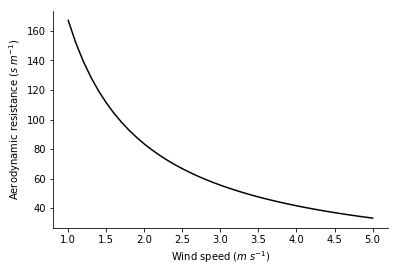

In [28]:
def calculate_ra(zu, d, z0, kv, u, Ts, Ta, g=9.81):
    
    delta = 5 * g * (zu - d) * (Ts - Ta) / (Ta * u**2)
    
    if type(delta) == float:
        if delta < 0:
            epsilon = -2.0
        else:
            epsilon = -0.75
    elif type(delta) == np.ndarray:
        epsilon = np.zeros_like(delta)
        epsilon[delta<0] == -2.
        epsilon[delta>=0] == -0.75
        
    ra = np.log((zu-d)/z0)**2 / (u * kv**2) * (1+delta)**epsilon
    
    return ra

# 
#Ts = np.linspace(0, 100, 101)
#Tss = [0.0, 50.0, 100.0]
ras = [calculate_ra(dz, d, z0, kv, u, Ts_ra, Ta) for z0, d in zip(z0s, ds)]

fig, ax = pl.subplots(1, 1)
#ax.plot(Ts, ras, color='black')

for ra, color, label in zip(ras, colors, labels):
    ax.plot(u, ra, color=color, label=label)

if len(labels) > 1:
    ax.legend(frameon=False)

#ax.set_xlabel('Surface temperature (degr. C)')
ax.set_xlabel(r'Wind speed ($m\;s^{-1}$)')
ax.set_ylabel(r'Aerodynamic resistance ($s\;m^{-1}$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/aerodynamic_resistance.pdf')

In [29]:
ras[0][u==2.0]

array([83.49841439])

next calculate the sensible heat flux (H), the latent heat flux (LE) and the heat transfer coefficients for sensible and latent heat flux (Ks and Kl). The equations are based on Bateni and Entekhabi (2012) WRR 48 (4).

In [30]:
def Magnus_eq(T):
    
    P = 0.61094 * np.exp(17.625 * T / (T + 243.04))
        
    return P * 1000.0


def calculate_heat_transfer_coeff_sensible_hf(rho, c, ra, dz):
    """
    
    """
    
    Ksi = rho * c / ra * dz
        
    return Ksi


def calculate_heat_transfer_coeff_latent_hf(Ts, Ta, Pa, RH_air, rho, L, dz, ra):
    """
    
    """
    
    esa = Magnus_eq(Ta)
    qa_sat = 0.622 * esa / Pa
    qa = qa_sat * RH_air

    ess = Magnus_eq(Ts)
    qs = 0.622 * ess / Pa
    
    Kl = rho * L * dz / ra * (qs - qa) / (Ts - Ta)

    return Kl

Kss = []
Kls = []
Kts = []

for ra in ras_plot:

    H = rho * c / ra * (Ts_plot - Ta)

    #print('calculated sensible heat flux = %0.2f W m-2' % H)

    #Ksi = rho * c / ra * dz
    Ksi = calculate_heat_transfer_coeff_sensible_hf(rho, c, ra, dz)
    Ks = np.ones_like(Ts_plot) * Ksi
    #print('calculated conductivity for sensible heat flux: %0.2f W m-1 K-1' % Ks)

    # calculate saturated specific humidity surface and air
    esa = Magnus_eq(Ta)
    qa_sat = 0.622 * esa / Pa
    qa = qa_sat * RH_air

    ess = Magnus_eq(Ts_plot)
    qs = 0.622 * ess / Pa

    LE = rho * L / ra * (qs - qa)

    #print('calculated potential latent heat flux = %0.2f W m-2' % LE)

    #Kl = rho * L * dz / ra * (qs - qa) / (Ts - Ta)
    Kl = calculate_heat_transfer_coeff_latent_hf(Ts_plot, Ta, Pa, RH_air, rho, L, dz, ra)
    
    #print('calculated conductivity for latent heat flux: %0.2f W m-1 K-1' % Kl)

    #K = (H + LE) * dz / (Ts - Ta)
    K = Ks + Kl
    
    Kss.append(Ks)
    Kls.append(Kl)
    Kts.append(K)

and finally make a figure of the heat transfer coefficient and how it depends on temperature:

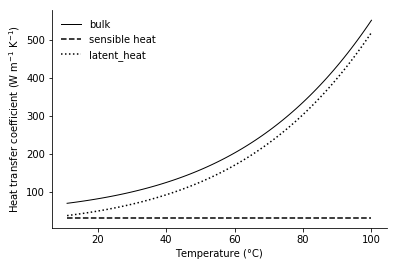

In [31]:
fig, ax = pl.subplots(1, 1)

for Ktsi, Kssi, Klsi, color in zip(Kts, Kss, Kls, colors):
    leg_bulk, = ax.plot(Ts_plot, Ktsi, color=color, lw=1.0, ls='-')
    leg_sens, = ax.plot(Ts_plot, Kssi, color=color, lw=1.5, ls='--')
    leg_lat, = ax.plot(Ts_plot, Klsi, color=color, lw=1.5, ls=':')

degree_symbol = chr(176)
ax.set_xlabel('Temperature (%sC)' % degree_symbol)
ax.set_ylabel(r'Heat transfer coefficient (W m$^{-1}$ K$^{-1}$)')

legs = [leg_bulk, leg_sens, leg_lat]
labels = ['bulk', 'sensible heat', 'latent_heat', ]

ax.legend(legs, labels, frameon=False, loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('fig/heat_transfer_coefficient.pdf')